In [1]:
# Libraries
import mysql.connector
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import cryptocode

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Encryption
encoded = cryptocode.encrypt("Nls@123","encryption_key")
decoded = cryptocode.decrypt(encoded, "encryption_key")

In [3]:
# Selecting the outcomes which has picked the calls
outcome = pd.read_csv('../data/Stanbic_Outcomes.csv')
outcome = outcome[outcome['CALL'].isin(['PICKED'])]
outcome = outcome['OUTCOME'].tolist()
# converting list to string
outcome = ', '.join(f"'{w}'" for w in outcome)
outcome

"'Disputing Balance', 'PTP', 'RESTRUCTURE', 'Setoff', 'Negotiation in Progress', 'Written Off-Outsource', 'MOVE TO REPOSSESSION', 'Full settlement', 'PTP Reminder', 'Lien', 'Written Off But Paid Off-Please Close', 'Language Barrier'"

In [4]:
# MYSQL Connection string

config = {
  'user': 'root',
  'password': 'Nls@123',
  'host': '127.0.0.1',
  'port':3306,
  'database': 'kollect_stanbic',
  'auth_plugin' : 'mysql_native_password',
  'raise_on_warnings': True
}

In [5]:
# Fetch the data from DB
mysql_connection = mysql.connector.connect(**config)
df = pd.read_sql('SELECT * from customer$information where outcome in ('+outcome+')', con=mysql_connection)
mysql_connection.close()
df.head()

,ID,GENDER,CUSTOMER_RISK_STATUS,INDUSTRY,RESIDENCE,CUSTOMER_STATUS,SEGMENT,BRANCH,PROMISE_SUCCESS,OUTCOME,...,VERSION_NUMBER,GROUP_NAME,DELINQUENCY_STRING,DELINQUENT_STATUS,DAO_AREA,LOAN_STATUS,REPAY_FREQUENCY,REPAY_CURRENCY,LOAN_TYPE,STAGE
0,1016480,MALE,26,1302,KE,4,CHNW,KE0010002-Kenyatta Avenue,NO,Negotiation in Progress,...,3,PERSONAL.LN,PERSONAL BANKING,CURRENT,Head of HR,CUR,e0Y e1M e0W o28D e0F,KES,Staff Loans Ordinary,
1,1016480,MALE,26,1302,KE,4,CHNW,KE0010002-Kenyatta Avenue,NO,Negotiation in Progress,...,4,HOME.LOAN,PERSONAL BANKING,CURRENT,Kenyatta Avenue Branch,NPL,e0Y e1M e0W o28D e0F,KES,Home Loans Staff,COLLECTION
2,1016480,MALE,26,1302,KE,4,CHNW,KE0010007-Chiromo,NO,Negotiation in Progress,...,5,PERSONAL.LN,PERSONAL BANKING,CURRENT,Kenyatta Avenue Branch,NPL,e0Y e1M e0W o28D e0F,KES,Staff Loans Special,COLLECTION
3,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,YES,PTP,...,2,MOBILE.DIGITAL.LENDING,PERSONAL BANKING,CURRENT,PERSONAL BANKING-SALARIED,NPL,e0Y e1M e0W o28D e0F,KES,Mobile Cash Advance Loan,COLLECTION
4,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,YES,PTP,...,3,MOBILE.DIGITAL.LENDING,PERSONAL BANKING,CURRENT,PERSONAL BANKING-SALARIED,NPL,e0Y e1M e0W o28D e0F,KES,Mobile Cash Advance Loan,COLLECTION


In [6]:
# Validating the null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36722 entries, 0 to 36721
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    36722 non-null  object
 1   GENDER                36722 non-null  object
 2   CUSTOMER_RISK_STATUS  36722 non-null  object
 3   INDUSTRY              36722 non-null  object
 4   RESIDENCE             36722 non-null  object
 5   CUSTOMER_STATUS       36722 non-null  object
 6   SEGMENT               36722 non-null  object
 7   BRANCH                36722 non-null  object
 8   PROMISE_SUCCESS       36722 non-null  object
 9   OUTCOME               36722 non-null  object
 10  TIME_STAMP            36722 non-null  object
 11  ACTIVITY              36722 non-null  object
 12  VERSION_NUMBER        36722 non-null  object
 13  GROUP_NAME            36722 non-null  object
 14  DELINQUENCY_STRING    36722 non-null  object
 15  DELINQUENT_STATUS     36722 non-null

In [7]:
# Removing the duplicated values
df = df.drop_duplicates(["ID", "TIME_STAMP"],ignore_index = True)

In [8]:
# Missing value treatment
# Using forward fill replacing the NA values
df = df.fillna(method='ffill')

# Changing timestamp to pandas datetime
df['TIME_STAMP'] = pd.to_datetime(df['TIME_STAMP'], errors='coerce')

# Droping the NA Rows
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


# Revalidating the null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36711 entries, 0 to 36710
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    36711 non-null  object        
 1   GENDER                36711 non-null  object        
 2   CUSTOMER_RISK_STATUS  36711 non-null  object        
 3   INDUSTRY              36711 non-null  object        
 4   RESIDENCE             36711 non-null  object        
 5   CUSTOMER_STATUS       36711 non-null  object        
 6   SEGMENT               36711 non-null  object        
 7   BRANCH                36711 non-null  object        
 8   PROMISE_SUCCESS       36711 non-null  object        
 9   OUTCOME               36711 non-null  object        
 10  TIME_STAMP            36711 non-null  datetime64[ns]
 11  ACTIVITY              36711 non-null  object        
 12  VERSION_NUMBER        36711 non-null  object        
 13  GROUP_NAME      

In [9]:
# In the above dataframe dropping ACTIVITY,VERSION_NUMBER,DELINQUENCY_STRING,DELINQUENT_STATUS columns
# ACTIVITY will be only call and added for data filter purpose
# VERSION_NUMBER will be only for same customers call count
# DELINQUENCY_STRING and SEGMENT are same, dropping one
# DELINQUENT_STATUS and CUSTOMER_RISK_STATUS are same, dropping one

df = df.drop(["ACTIVITY","VERSION_NUMBER","DELINQUENCY_STRING","DELINQUENT_STATUS"], axis = 1)
df.head()

,ID,GENDER,CUSTOMER_RISK_STATUS,INDUSTRY,RESIDENCE,CUSTOMER_STATUS,SEGMENT,BRANCH,PROMISE_SUCCESS,OUTCOME,TIME_STAMP,GROUP_NAME,DAO_AREA,LOAN_STATUS,REPAY_FREQUENCY,REPAY_CURRENCY,LOAN_TYPE,STAGE
0,1016480,MALE,26,1302,KE,4,CHNW,KE0010002-Kenyatta Avenue,NO,Negotiation in Progress,2022-01-03 08:23:06,PERSONAL.LN,Head of HR,CUR,e0Y e1M e0W o28D e0F,KES,Staff Loans Ordinary,
1,1016480,MALE,26,1302,KE,4,CHNW,KE0010002-Kenyatta Avenue,NO,Negotiation in Progress,2022-03-07 08:04:33,HOME.LOAN,Kenyatta Avenue Branch,NPL,e0Y e1M e0W o28D e0F,KES,Home Loans Staff,COLLECTION
2,1016480,MALE,26,1302,KE,4,CHNW,KE0010007-Chiromo,NO,Negotiation in Progress,2022-03-09 16:15:17,PERSONAL.LN,Kenyatta Avenue Branch,NPL,e0Y e1M e0W o28D e0F,KES,Staff Loans Special,COLLECTION
3,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,YES,PTP,2021-12-01 12:24:36,MOBILE.DIGITAL.LENDING,PERSONAL BANKING-SALARIED,NPL,e0Y e1M e0W o28D e0F,KES,Mobile Cash Advance Loan,COLLECTION
4,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,YES,PTP,2021-12-06 09:02:59,MOBILE.DIGITAL.LENDING,PERSONAL BANKING-SALARIED,NPL,e0Y e1M e0W o28D e0F,KES,Mobile Cash Advance Loan,COLLECTION


In [10]:
# Creating hours to sessions 

df_time = pd.DataFrame({'hour':range(0, 24)})

split = [0,3,5,9,12,14,16,18,20,23]
session = ['Late_Night','Early_Morning','Morning','Late_Morning','Afteroon','Late_Afternoon','Evening','Late_Evening','Night']
df_time['session'] = pd.cut(df_time['hour'], bins=split, labels=session, include_lowest=True)

df_time

,hour,session
0,0,Late_Night
1,1,Late_Night
2,2,Late_Night
3,3,Late_Night
4,4,Early_Morning
5,5,Early_Morning
6,6,Morning
7,7,Morning
8,8,Morning
9,9,Morning


In [11]:
preffered_session = "Late_Afternoon"
session_index = session.index(preffered_session)
time_split = str(split[session_index]) +'-'+ str(split[session_index+1])
time_split

'14-16'

In [12]:
# Converting timestamp to session

split = [0,3,5,9,12,14,16,18,20,23]
session = ['Late_Night','Early_Morning','Morning','Late_Morning','Afteroon','Late_Afternoon','Evening','Late_Evening','Night']
df['SESSION'] = pd.cut(df.TIME_STAMP.dt.hour, bins=split, labels=session, include_lowest=True)

df.head()

,ID,GENDER,CUSTOMER_RISK_STATUS,INDUSTRY,RESIDENCE,CUSTOMER_STATUS,SEGMENT,BRANCH,PROMISE_SUCCESS,OUTCOME,TIME_STAMP,GROUP_NAME,DAO_AREA,LOAN_STATUS,REPAY_FREQUENCY,REPAY_CURRENCY,LOAN_TYPE,STAGE,SESSION
0,1016480,MALE,26,1302,KE,4,CHNW,KE0010002-Kenyatta Avenue,NO,Negotiation in Progress,2022-01-03 08:23:06,PERSONAL.LN,Head of HR,CUR,e0Y e1M e0W o28D e0F,KES,Staff Loans Ordinary,,Morning
1,1016480,MALE,26,1302,KE,4,CHNW,KE0010002-Kenyatta Avenue,NO,Negotiation in Progress,2022-03-07 08:04:33,HOME.LOAN,Kenyatta Avenue Branch,NPL,e0Y e1M e0W o28D e0F,KES,Home Loans Staff,COLLECTION,Morning
2,1016480,MALE,26,1302,KE,4,CHNW,KE0010007-Chiromo,NO,Negotiation in Progress,2022-03-09 16:15:17,PERSONAL.LN,Kenyatta Avenue Branch,NPL,e0Y e1M e0W o28D e0F,KES,Staff Loans Special,COLLECTION,Late_Afternoon
3,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,YES,PTP,2021-12-01 12:24:36,MOBILE.DIGITAL.LENDING,PERSONAL BANKING-SALARIED,NPL,e0Y e1M e0W o28D e0F,KES,Mobile Cash Advance Loan,COLLECTION,Late_Morning
4,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,YES,PTP,2021-12-06 09:02:59,MOBILE.DIGITAL.LENDING,PERSONAL BANKING-SALARIED,NPL,e0Y e1M e0W o28D e0F,KES,Mobile Cash Advance Loan,COLLECTION,Morning


In [13]:
# Analyzing categorical values in the dataframe
cols = df.columns
num_cols = df._get_numeric_data().columns
categorical_col = list(set(cols) - set(num_cols))
    
categorical_col

['GENDER',
 'DAO_AREA',
 'BRANCH',
 'PROMISE_SUCCESS',
 'TIME_STAMP',
 'CUSTOMER_RISK_STATUS',
 'LOAN_TYPE',
 'LOAN_STATUS',
 'REPAY_FREQUENCY',
 'GROUP_NAME',
 'CUSTOMER_STATUS',
 'STAGE',
 'INDUSTRY',
 'SEGMENT',
 'REPAY_CURRENCY',
 'SESSION',
 'ID',
 'OUTCOME',
 'RESIDENCE']

In [14]:
# Validating the catorical values (Duplicates)
print("STAGE",df['STAGE'].unique())
print("LOAN_STATUS",df['LOAN_STATUS'].unique())
print("PROMISE_SUCCESS",df['PROMISE_SUCCESS'].unique())
print("CUSTOMER_RISK_STATUS",df['CUSTOMER_RISK_STATUS'].unique())
print("OUTCOME",df['OUTCOME'].unique())
print("REPAY_FREQUENCY",df['REPAY_FREQUENCY'].unique())

print("CUSTOMER_STATUS",df['CUSTOMER_STATUS'].unique())
print("GENDER",df['GENDER'].unique())
print("GROUP_NAME",df['GROUP_NAME'].unique())
print("SESSION",df['SESSION'].unique())
print("RESIDENCE",df['RESIDENCE'].unique())
print("REPAY_CURRENCY",df['REPAY_CURRENCY'].unique())

print("DAO_AREA",df['DAO_AREA'].unique())
print("SEGMENT",df['SEGMENT'].unique())
print("LOAN_TYPE",df['LOAN_TYPE'].unique())
print("BRANCH",df['BRANCH'].unique())

STAGE ['' 'COLLECTION']
LOAN_STATUS ['CUR' 'NPL' 'OD2' 'OD1' 'OD3' 'OD4']
PROMISE_SUCCESS ['NO' 'YES']
CUSTOMER_RISK_STATUS ['26' '28' '18' '25' '7' '21' '15' '22' '20' '8' '19' 'D' '16' '9' 'W'
 '17' '24' '0' '' '23' '2' '14']
OUTCOME ['Negotiation in Progress' 'PTP' 'PTP Reminder' 'Setoff' 'Lien'
 'MOVE TO REPOSSESSION' 'Full settlement' 'RESTRUCTURE'
 'Written Off-Outsource' 'Disputing Balance'
 'Written Off But Paid Off-Please Close' 'Language Barrier']
REPAY_FREQUENCY ['e0Y e1M e0W o28D e0F' 'e0Y e1M e0W o27D e0F']
CUSTOMER_STATUS ['4' '52' '5' '20' '21']
GENDER ['MALE' '' 'FEMALE']
GROUP_NAME ['PERSONAL.LN' 'HOME.LOAN' 'MOBILE.DIGITAL.LENDING' 'VAF.LOAN'
 'BUSINESS.LOAN' 'SBKDeposits' 'SAFRCOM.LN' 'SUPP.DISTR.LOAN']
SESSION ['Morning', 'Late_Afternoon', 'Late_Morning', 'Afteroon', 'Evening', 'Late_Evening']
Categories (9, object): ['Late_Night' < 'Early_Morning' < 'Morning' < 'Late_Morning' ... 'Late_Afternoon' < 'Evening' < 'Late_Evening' < 'Night']
RESIDENCE ['KE' 'SL']
REPAY_C

In [15]:
# # Replacing the duplicated catogorical values 
# df["OUTCOME"] = df["OUTCOME"].replace("Un-REACHABLE","UNREACHABLE")
# df["OUTCOME"] = df["OUTCOME"].replace("Un-REACHABLE Trace","UNREACHABLE")

# # Replacing All Unreachable, Invalid Contact with out sub commands to group all together
# df.loc[df['OUTCOME'].str.contains('Unreachable'), 'OUTCOME'] = 'Unreachable'
# df.loc[df['OUTCOME'].str.contains('Invalid Contact'), 'OUTCOME'] = 'Invalid Contact'

# # removing the Invalid contact since It's not a part valid data
# df = df[~df.isin(['Invalid Contact']).any(axis=1)]

# Replacing Customer_Risk_Status Letter with the respective values
df["CUSTOMER_RISK_STATUS"] = df["CUSTOMER_RISK_STATUS"].replace(['D','W','F','I'],[51,52,53,54])

# Replacing the empty string to NA
df.replace(r'', np.NaN, inplace=True)

# Droping the NA Rows
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
# Analyzing the dependent variable categories
print('dependent variable categories -Sessions' ,df['SESSION'].unique())

# count values of each categories 
print(df['SESSION'].value_counts())

dependent variable categories -Sessions ['Morning', 'Late_Afternoon', 'Late_Morning', 'Afteroon', 'Evening', 'Late_Evening']
Categories (9, object): ['Late_Night' < 'Early_Morning' < 'Morning' < 'Late_Morning' ... 'Late_Afternoon' < 'Evening' < 'Late_Evening' < 'Night']
Late_Morning      10482
Late_Afternoon     7948
Afteroon           4940
Morning            4086
Evening             931
Late_Evening          3
Late_Night            0
Early_Morning         0
Night                 0
Name: SESSION, dtype: int64


In [17]:
# Grouping the ID with sessions to get each customer call count against each session
df['FREQ'] = df.groupby(["ID","SESSION","PROMISE_SUCCESS"])['SESSION'].transform('count')
df.head()

,ID,GENDER,CUSTOMER_RISK_STATUS,INDUSTRY,RESIDENCE,CUSTOMER_STATUS,SEGMENT,BRANCH,PROMISE_SUCCESS,OUTCOME,TIME_STAMP,GROUP_NAME,DAO_AREA,LOAN_STATUS,REPAY_FREQUENCY,REPAY_CURRENCY,LOAN_TYPE,STAGE,SESSION,FREQ
0,1016480,MALE,26,1302,KE,4,CHNW,KE0010002-Kenyatta Avenue,NO,Negotiation in Progress,2022-03-07 08:04:33,HOME.LOAN,Kenyatta Avenue Branch,NPL,e0Y e1M e0W o28D e0F,KES,Home Loans Staff,COLLECTION,Morning,1
1,1016480,MALE,26,1302,KE,4,CHNW,KE0010007-Chiromo,NO,Negotiation in Progress,2022-03-09 16:15:17,PERSONAL.LN,Kenyatta Avenue Branch,NPL,e0Y e1M e0W o28D e0F,KES,Staff Loans Special,COLLECTION,Late_Afternoon,1
2,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,YES,PTP,2021-12-01 12:24:36,MOBILE.DIGITAL.LENDING,PERSONAL BANKING-SALARIED,NPL,e0Y e1M e0W o28D e0F,KES,Mobile Cash Advance Loan,COLLECTION,Late_Morning,6
3,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,YES,PTP,2021-12-06 09:02:59,MOBILE.DIGITAL.LENDING,PERSONAL BANKING-SALARIED,NPL,e0Y e1M e0W o28D e0F,KES,Mobile Cash Advance Loan,COLLECTION,Morning,5
4,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,YES,PTP,2022-01-05 09:54:15,MOBILE.DIGITAL.LENDING,PERSONAL BANKING-SALARIED,NPL,e0Y e1M e0W o28D e0F,KES,Mobile Cash Advance Loan,COLLECTION,Morning,5


In [18]:
# Removing the duplicated values
df = df.drop_duplicates(["ID","SESSION","PROMISE_SUCCESS"],ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13236 entries, 0 to 13235
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ID                    13236 non-null  object        
 1   GENDER                13236 non-null  object        
 2   CUSTOMER_RISK_STATUS  13236 non-null  object        
 3   INDUSTRY              13236 non-null  object        
 4   RESIDENCE             13236 non-null  object        
 5   CUSTOMER_STATUS       13236 non-null  object        
 6   SEGMENT               13236 non-null  object        
 7   BRANCH                13236 non-null  object        
 8   PROMISE_SUCCESS       13236 non-null  object        
 9   OUTCOME               13236 non-null  object        
 10  TIME_STAMP            13236 non-null  datetime64[ns]
 11  GROUP_NAME            13236 non-null  object        
 12  DAO_AREA              13236 non-null  object        
 13  LOAN_STATUS     

In [19]:
# Analyzing the call count
print("Frequency call unique count",df['FREQ'].unique())
print("Frequency call count",len(df['FREQ'].unique()))

Frequency call unique count [ 1  6  5  2  3  4  9  7  8 12 10 21 11 14 13 24 16 19 15 17 22 23]
Frequency call count 22


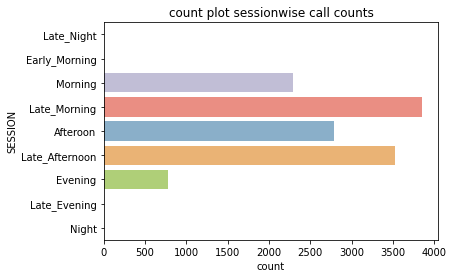

In [20]:
# Basic data analysis using visualization

# count plot for sessionwise call counts
sns.countplot(y='SESSION',data=df,palette='Set3')
plt.title("count plot sessionwise call counts")
plt.show()

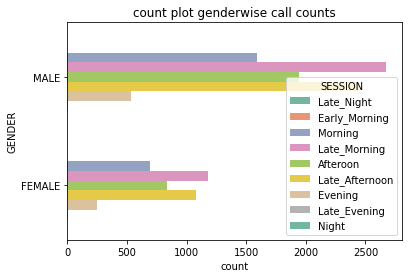

In [21]:
# count plot for genderwise call counts
sns.countplot(y='GENDER',hue='SESSION',data=df,palette='Set2')
plt.title("count plot genderwise call counts")
plt.show()

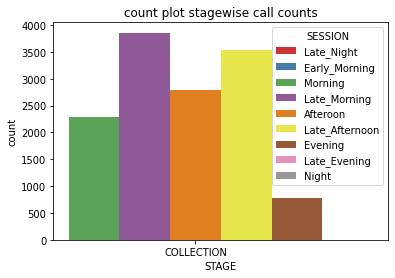

In [22]:
# count plot for stagewise call counts
sns.countplot(x='STAGE',hue='SESSION',data=df,palette='Set1')
plt.title("count plot stagewise call counts")
plt.show()

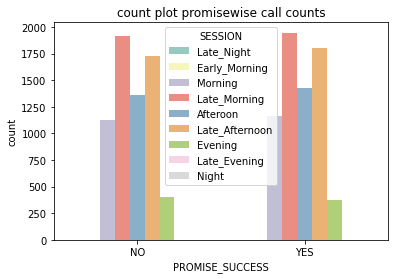

In [23]:
# count plot for promisewise call counts
sns.countplot(x='PROMISE_SUCCESS',hue='SESSION',data=df,palette='Set3')
plt.title("count plot promisewise call counts")
plt.show()

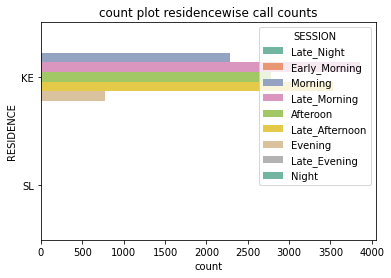

In [24]:
# count plot for residencewise call counts
sns.countplot(y='RESIDENCE',hue='SESSION',data=df,palette='Set2')
plt.title("count plot residencewise call counts")
plt.show()

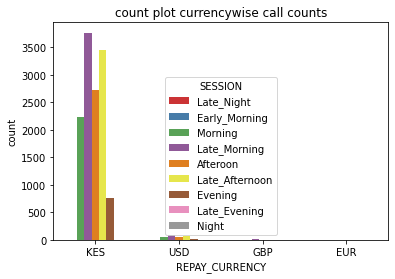

In [25]:
# count plot for currencywise call counts
sns.countplot(x='REPAY_CURRENCY',hue='SESSION',data=df,palette='Set1')
plt.title("count plot currencywise call counts")
plt.show()

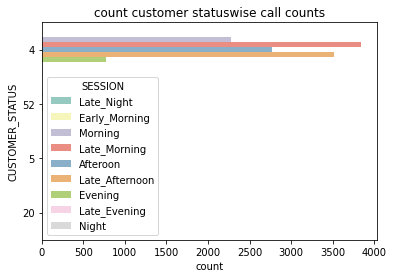

In [26]:
# count plot for customer statuswise call counts
sns.countplot(y='CUSTOMER_STATUS',hue='SESSION',data=df,palette='Set3')
plt.title("count customer statuswise call counts")
plt.show()

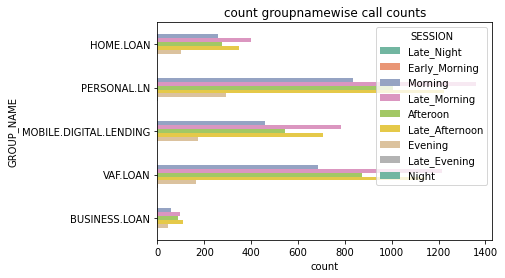

In [27]:
# count plot for groupnamewise call counts
sns.countplot(y='GROUP_NAME',hue='SESSION',data=df,palette='Set2')
plt.title("count groupnamewise call counts")
plt.show()

In [28]:
# pivoting the table using unique id and promise status
df_pivot = df.pivot_table(index=['ID', 'PROMISE_SUCCESS'], columns='SESSION', values='FREQ').reset_index()
df_pivot.fillna(0, inplace=True)
df_pivot.head()

SESSION,ID,PROMISE_SUCCESS,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening
0,1016480,NO,1.0,0.0,0.0,1.0,0.0,0.0
1,1016628,NO,0.0,2.0,1.0,3.0,0.0,0.0
2,1016628,YES,5.0,6.0,2.0,3.0,0.0,0.0
3,1016969,NO,2.0,4.0,1.0,2.0,1.0,0.0
4,1016969,YES,2.0,6.0,1.0,2.0,0.0,0.0


In [29]:
# merging 2 dataframes
df = pd.merge(df, df_pivot, on=['ID','PROMISE_SUCCESS'])
df = df.drop_duplicates(["ID","PROMISE_SUCCESS"],ignore_index = True)
df.head()

,ID,GENDER,CUSTOMER_RISK_STATUS,INDUSTRY,RESIDENCE,CUSTOMER_STATUS,SEGMENT,BRANCH,PROMISE_SUCCESS,OUTCOME,...,LOAN_TYPE,STAGE,SESSION,FREQ,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening
0,1016480,MALE,26,1302,KE,4,CHNW,KE0010002-Kenyatta Avenue,NO,Negotiation in Progress,...,Home Loans Staff,COLLECTION,Morning,1,1.0,0.0,0.0,1.0,0.0,0.0
1,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,YES,PTP,...,Mobile Cash Advance Loan,COLLECTION,Late_Morning,6,5.0,6.0,2.0,3.0,0.0,0.0
2,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,NO,PTP Reminder,...,Mobile Cash Advance Loan,COLLECTION,Afteroon,1,0.0,2.0,1.0,3.0,0.0,0.0
3,1016969,MALE,18,1302,KE,4,CHNW,KE0010023-Karen,YES,PTP,...,Secured Personal Term Loan,COLLECTION,Morning,2,2.0,6.0,1.0,2.0,0.0,0.0
4,1016969,MALE,18,1302,KE,4,CHNW,KE0010031-TWO RIVERS - TWO,NO,Setoff,...,Home Loans Ordinary,COLLECTION,Morning,2,2.0,4.0,1.0,2.0,1.0,0.0


In [30]:
# # SUM up each session against the user
# df_Session = df.loc[df['OUTCOME'] != 'Unreachable'].groupby(['ID','PROMISE_SUCCESS'])['Morning','Late_Morning','Afteroon','Late_Afternoon','Evening','Late_Evening'].sum()
# df_Session.head()

In [31]:
# # spliting not reachable data into one and remain in df
# df_Unreachable = df.loc[df['OUTCOME'] == 'Unreachable']
# df = df.loc[df['OUTCOME'] != 'Unreachable']

In [32]:
# # deleting existing session columns
# df = df.drop(['Morning','Late_Morning','Afteroon','Late_Afternoon','Evening','Late_Evening'], axis = 1)
# # merging session column with the dataframe
# df = pd.merge(df, df_Session, on=['ID','PROMISE_SUCCESS'])
# # droping duplicates
# df = df.drop_duplicates(["ID","PROMISE_SUCCESS"],ignore_index = True)
# df.head()

In [33]:
# Added preffered session to the respective customer
avl_session = df['SESSION'].unique().tolist()
df['PREF_SESSION'] = df[avl_session].idxmax(axis=1)
df.head()

,ID,GENDER,CUSTOMER_RISK_STATUS,INDUSTRY,RESIDENCE,CUSTOMER_STATUS,SEGMENT,BRANCH,PROMISE_SUCCESS,OUTCOME,...,STAGE,SESSION,FREQ,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,PREF_SESSION
0,1016480,MALE,26,1302,KE,4,CHNW,KE0010002-Kenyatta Avenue,NO,Negotiation in Progress,...,COLLECTION,Morning,1,1.0,0.0,0.0,1.0,0.0,0.0,Morning
1,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,YES,PTP,...,COLLECTION,Late_Morning,6,5.0,6.0,2.0,3.0,0.0,0.0,Late_Morning
2,1016628,MALE,28,1302,KE,4,CHNW,KE0010013-Kisumu,NO,PTP Reminder,...,COLLECTION,Afteroon,1,0.0,2.0,1.0,3.0,0.0,0.0,Late_Afternoon
3,1016969,MALE,18,1302,KE,4,CHNW,KE0010023-Karen,YES,PTP,...,COLLECTION,Morning,2,2.0,6.0,1.0,2.0,0.0,0.0,Late_Morning
4,1016969,MALE,18,1302,KE,4,CHNW,KE0010031-TWO RIVERS - TWO,NO,Setoff,...,COLLECTION,Morning,2,2.0,4.0,1.0,2.0,1.0,0.0,Late_Morning


In [34]:
# # Added not preffered session to the respective customer
# df_Unreachable['NOT_PREF_SESSION'] = df_Unreachable[session].idxmax(axis=1)

In [35]:
# # Merging Not preferred session with existing dataframe using left join
# df = pd.merge(df,df_Unreachable[['ID','PROMISE_SUCCESS','NOT_PREF_SESSION']],on=['ID','PROMISE_SUCCESS'], how='left')
# df.head()

In [36]:
# Removing the below columns from the dataframe
# ID, performed all operations against the unique id
# BRANCH, no useful information 
# TIME_STAMP converted to sessions
# FREQ, for developer reference
df = df.drop(["ID","BRANCH","TIME_STAMP","FREQ","LOAN_TYPE","SESSION"], axis = 1)

In [37]:
# To do one hot encode the categories
# added the parameter drop_first is true in one hot , always n-1 columns enough to explain the categories
df_final = pd.get_dummies(df, drop_first =True ,columns=["RESIDENCE","GENDER", "SEGMENT",
                                                         "PROMISE_SUCCESS","OUTCOME","GROUP_NAME","LOAN_STATUS",
                                                         "REPAY_CURRENCY","STAGE","DAO_AREA"],dtype = int,
                          sparse=True)

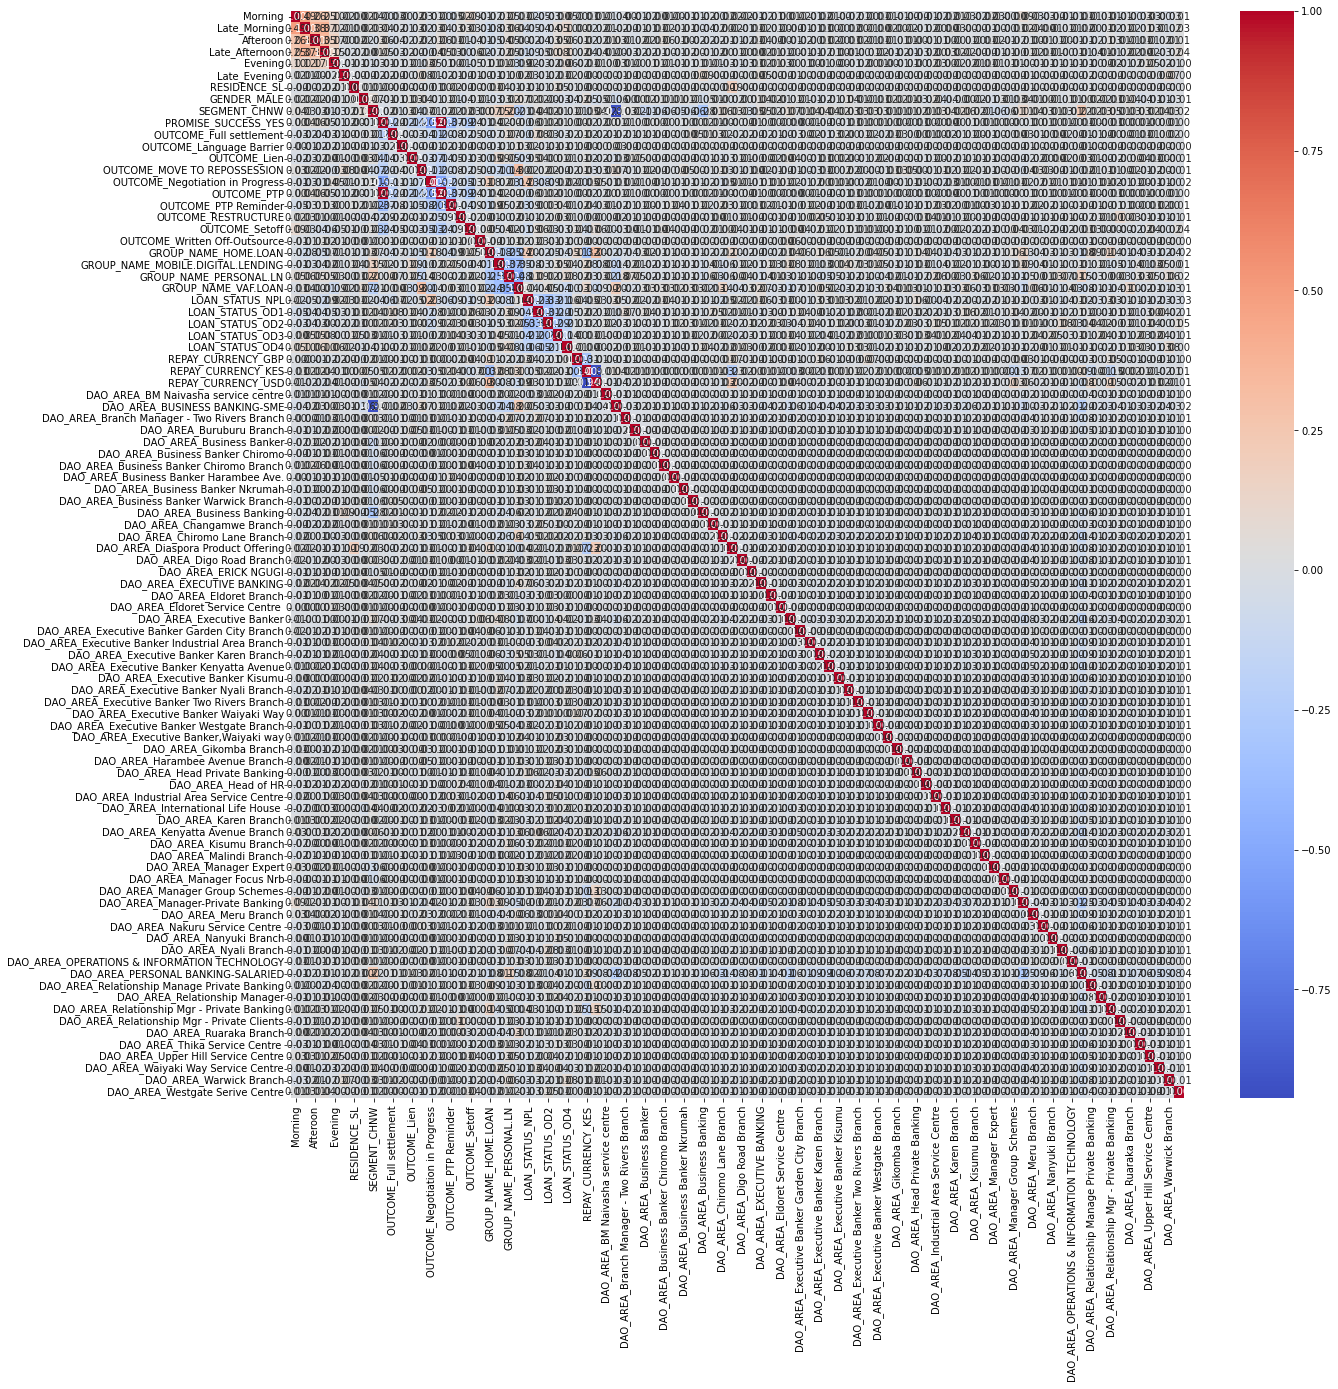

In [38]:
# Corelation Matrix
# added the parameter fmt =.2f for 2 decimal representation
# In a more general situation, when you have two independent variables that are very highly correlated, 
# you definitely should remove one of them because you run into the multicollinearity conundrum and your 
# regression model's regression coefficients related to the two highly correlated variables will be unreliable

plt.figure(figsize=(20,20))
sns.heatmap(df_final[list(df_final.columns)].corr(),annot=True,cmap="coolwarm",fmt=".2f")
plt.show()

In [39]:
# jsonList=[]
# a = df['REPAY_FREQUENCY'].unique()
# b = np.arange(0,len(df['REPAY_FREQUENCY'].unique()),1).tolist()

# # print(a)
# # print(b)

# for i in range(0,len(a)):
#     jsonList.append({a[i] : b[i]})

# json.dumps(jsonList)

In [40]:
# Binning, Replacing categories with values

df_final = df_final.replace({"REPAY_FREQUENCY" : {'e0Y e1M e0W o21D e0F':1, 'e0Y e1M e0W o14D e0F':2, 'e0Y e1M e0W o25D e0F':3,
                                      'e0Y e1M e0W o2D e0F':4, 'e0Y e1M e0W o5D e0F':5, 'e0Y e1M e0W o19D e0F':6,
                                      'e0Y e1M e0W o26D e0F':7,'e0Y e1M e0W o15D e0F':8, 'e0Y e1M e0W o3D e0F':9,
                                      'e0Y e1M e0W o18D e0F':10,'e0Y e1M e0W o24D e0F':11, 'e0Y e1M e0W o4D e0F':12,
                                      'e0Y e1M e0W o6D e0F':13,'e0Y e1M e0W o16D e0F':14, 'e0Y e1M e0W o13D e0F':15,
                                      'e0Y e1M e0W o22D e0F':16, 'e0Y e1M e0W e0D e0F':17, 'e0Y e1M e0W o23D e0F':18,
                                      'e0Y e1M e0W o10D e0F':19, 'e0Y e1M e0W o8D e0F':20, 'e0Y e1M e0W o9D e0F':21,
                                      'e0Y e1M e0W o20D e0F':22, 'e0Y e1M e0W o11D e0F':23, 'e0Y e1M e0W o27D e0F':24,
                                      'e0Y e1M e0W o7D e0F':25, 'e0Y e1M e0W o28D e0F':26, 'e0Y e1M e0W oLD e0F':28,
                                      'e0Y e1M e0W o30D e0F':29, 'e0Y e1M e0W o17D e0F':30, 'e0Y e1M e0W o1D e0F':31,
                                      'e0Y e1M e0W o12D e0F':32,'e0Y e1M e0W o29D e0F':33, 'e0Y e4M e0W o28D e0F':34,
                                      'e0Y e4M e0W o25D e0F':35, 'e0Y e0M e2W e0D e0F':36,'e0Y e1M e0W o31D e0F':37,
                                      'e0Y e3M e0W o15D e0F':38,'e0Y e3M e0W o1D e0F':39}})

# f_final = df_final.replace({"REPAY_FREQUENCY" :jsonList})

df_final = df_final.replace({"PREF_SESSION" : {'Morning':1,'Late_Morning':2,'Afteroon':3,
                                               'Late_Afternoon':4,'Evening':5,
                                               'Late_Evening':6,'Night':7,'Late_Night':8,
                                               'Early_Morning': 9}})

# df_final.to_csv("cleansed.csv")
df_final.tail()

,CUSTOMER_RISK_STATUS,INDUSTRY,CUSTOMER_STATUS,REPAY_FREQUENCY,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,...,DAO_AREA_Relationship Manage Private Banking,DAO_AREA_Relationship Manager,DAO_AREA_Relationship Mgr - Private Banking,DAO_AREA_Relationship Mgr - Private Clients,DAO_AREA_Ruaraka Branch,DAO_AREA_Thika Service Centre,DAO_AREA_Upper Hill Service Centre,DAO_AREA_Waiyaki Way Service Centre,DAO_AREA_Warwick Branch,DAO_AREA_Westgate Serive Centre
5167,18,1002,4,26,2.0,1.0,1.0,6.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5168,28,1302,4,26,2.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5169,28,1302,4,26,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5170,25,1302,4,26,1.0,0.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5171,25,1302,4,26,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# spliting the data to dependent and independent variable
y = df_final['PREF_SESSION'].copy()
X = df_final.drop('PREF_SESSION', axis=1)

# Splitting the dataset into the Training set and Test set. test size is 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [42]:
# Feature Scaling
# there is no need to apply future scaling on dependent variable
sc = StandardScaler()
X_sc = sc.fit_transform(X)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [43]:
from sklearn.decomposition import PCA
# feature extraction
pca = PCA(n_components = 'mle',svd_solver = 'full')
fit = pca.fit(X_sc,y)
# summarize componentsx
print('Total Explained variance: %.2f' % fit.explained_variance_ratio_.sum())
#print(fit.feature_names_in_)
print(np.round(fit.explained_variance_ratio_,3))
#print(fit.feature_names_in_)

Total Explained variance: 1.00
[0.029 0.026 0.026 0.023 0.019 0.017 0.016 0.015 0.014 0.013 0.013 0.013
 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.011 0.011 0.011 0.011 0.011
 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011 0.011
 0.011 0.011 0.011 0.011 0.011 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.009
 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.008 0.008 0.008 0.007
 0.007 0.007 0.006 0.006 0.005 0.001 0.    0.    0.    0.    0.   ]


In [44]:
# Variable percentage of explanation on dependent variable
sorted_idx = np.argsort(fit.explained_variance_ratio_)[::-1]

for index in sorted_idx:
    print([X.columns[index], np.round(fit.explained_variance_ratio_[index],3)]) 

['CUSTOMER_RISK_STATUS', 0.029]
['INDUSTRY', 0.026]
['CUSTOMER_STATUS', 0.026]
['REPAY_FREQUENCY', 0.023]
['Morning', 0.019]
['Late_Morning', 0.017]
['Afteroon', 0.016]
['Late_Afternoon', 0.015]
['Evening', 0.014]
['Late_Evening', 0.013]
['RESIDENCE_SL', 0.013]
['GENDER_MALE', 0.013]
['SEGMENT_CHNW', 0.012]
['PROMISE_SUCCESS_YES', 0.012]
['OUTCOME_Full settlement', 0.012]
['OUTCOME_Language Barrier', 0.012]
['OUTCOME_Lien', 0.012]
['OUTCOME_MOVE TO REPOSSESSION', 0.012]
['OUTCOME_Negotiation in Progress', 0.012]
['OUTCOME_PTP', 0.011]
['OUTCOME_PTP Reminder', 0.011]
['OUTCOME_RESTRUCTURE', 0.011]
['OUTCOME_Setoff', 0.011]
['OUTCOME_Written Off-Outsource', 0.011]
['GROUP_NAME_HOME.LOAN', 0.011]
['GROUP_NAME_MOBILE.DIGITAL.LENDING', 0.011]
['GROUP_NAME_PERSONAL.LN', 0.011]
['GROUP_NAME_VAF.LOAN', 0.011]
['LOAN_STATUS_NPL', 0.011]
['LOAN_STATUS_OD1', 0.011]
['LOAN_STATUS_OD2', 0.011]
['LOAN_STATUS_OD3', 0.011]
['LOAN_STATUS_OD4', 0.011]
['REPAY_CURRENCY_GBP', 0.011]
['REPAY_CURRENCY_KES',

In [45]:
# seperating cetogorical variable for MCA
categorical_col = ["RESIDENCE","GENDER", "CUSTOMER_STATUS", "SEGMENT","PROMISE_SUCCESS","OUTCOME","GROUP_NAME","LOAN_STATUS",
 "REPAY_CURRENCY","STAGE","DAO_AREA"]
categorical_df= df.reindex(categorical_col,axis="columns") 
categorical_df.head()

,RESIDENCE,GENDER,CUSTOMER_STATUS,SEGMENT,PROMISE_SUCCESS,OUTCOME,GROUP_NAME,LOAN_STATUS,REPAY_CURRENCY,STAGE,DAO_AREA
0,KE,MALE,4,CHNW,NO,Negotiation in Progress,HOME.LOAN,NPL,KES,COLLECTION,Kenyatta Avenue Branch
1,KE,MALE,4,CHNW,YES,PTP,MOBILE.DIGITAL.LENDING,NPL,KES,COLLECTION,PERSONAL BANKING-SALARIED
2,KE,MALE,4,CHNW,NO,PTP Reminder,MOBILE.DIGITAL.LENDING,NPL,KES,COLLECTION,PERSONAL BANKING-SALARIED
3,KE,MALE,4,CHNW,YES,PTP,PERSONAL.LN,CUR,KES,COLLECTION,Diaspora Product Offering
4,KE,MALE,4,CHNW,NO,Setoff,HOME.LOAN,OD2,KES,COLLECTION,Diaspora Product Offering


In [46]:
# Multiple Correspondence Analysis (MCA)
import prince
mca = prince.MCA(
    n_components=len(categorical_col),
    n_iter=100,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
mca = mca.fit(categorical_df,y)
print(np.round(mca.explained_inertia_,3))


[0.028 0.023 0.02  0.017 0.015 0.015 0.014 0.014 0.013 0.013 0.013]


In [47]:
# Variable percentage of explanation on dependent variable
print("Total explained variance  :", np.round(sum(mca.explained_inertia_),3))
sorted_idx = np.argsort(mca.explained_inertia_)[::-1]

for index in sorted_idx:
    print([categorical_col[index], np.round(mca.explained_inertia_[index],3)]) 

Total explained variance  : 0.184
['RESIDENCE', 0.028]
['GENDER', 0.023]
['CUSTOMER_STATUS', 0.02]
['SEGMENT', 0.017]
['PROMISE_SUCCESS', 0.015]
['OUTCOME', 0.015]
['GROUP_NAME', 0.014]
['LOAN_STATUS', 0.014]
['REPAY_CURRENCY', 0.013]
['STAGE', 0.013]
['DAO_AREA', 0.013]


In [48]:
# Model execution time calculation
from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


 Time taken: 0 hours 0 minutes and 4.45 seconds.


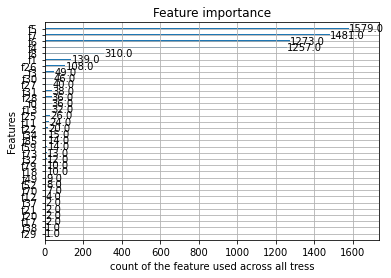

In [49]:
# plot feature importance using built-in function
from xgboost import XGBClassifier
from xgboost import plot_importance,plot_tree
from matplotlib import pyplot
# fit model no training data
model = XGBClassifier(n_estimators = 50,max_depth = 10, eta = 0.1,eval_metric ='error',objective='multi:softmax',
                     num_class = 9)

start_time = timer(None) # timing starts from this point for "start_time" variable
model.fit(X_train,y_train)

# plot feature importance
plot_importance(model,xlabel = 'count of the feature used across all tress')
timer(start_time) # timing ends here for "start_time" variable
pyplot.show()

In [50]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]

for index in sorted_idx:
    print([X.columns[index], model.feature_importances_[index]]) 

['Late_Morning', 0.31720284]
['Late_Afternoon', 0.19624075]
['Morning', 0.18592224]
['Afteroon', 0.1302975]
['Evening', 0.032835282]
['DAO_AREA_EXECUTIVE BANKING', 0.020979837]
['DAO_AREA_Diaspora Product Offering', 0.018462265]
['SEGMENT_CHNW', 0.008246297]
['OUTCOME_Setoff', 0.007406977]
['REPAY_FREQUENCY', 0.0066438033]
['LOAN_STATUS_NPL', 0.006618043]
['GROUP_NAME_PERSONAL.LN', 0.005981192]
['GENDER_MALE', 0.0056507327]
['DAO_AREA_Manager-Private Banking', 0.0054303436]
['DAO_AREA_Executive Banker Kenyatta Avenue', 0.004756992]
['DAO_AREA_Kenyatta Avenue Branch', 0.0046840403]
['INDUSTRY', 0.0042235577]
['OUTCOME_Negotiation in Progress', 0.0039657224]
['LOAN_STATUS_OD3', 0.003798909]
['LOAN_STATUS_OD2', 0.0032128491]
['REPAY_CURRENCY_KES', 0.0030492672]
['DAO_AREA_Industrial Area Service Centre', 0.0030396993]
['GROUP_NAME_VAF.LOAN', 0.0028938772]
['GROUP_NAME_MOBILE.DIGITAL.LENDING', 0.0026040438]
['DAO_AREA_BUSINESS BANKING-SME', 0.0021612959]
['OUTCOME_PTP Reminder', 0.00210769

In [51]:
# As per the PCA, XGB model importance and bussiness inputs dropping the below columns and recreation of 
# model with new dataset
df = df.drop(["OUTCOME","GROUP_NAME","REPAY_FREQUENCY","DAO_AREA","LOAN_STATUS","SEGMENT"], axis = 1)
df.head()

,GENDER,CUSTOMER_RISK_STATUS,INDUSTRY,RESIDENCE,CUSTOMER_STATUS,PROMISE_SUCCESS,REPAY_CURRENCY,STAGE,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,PREF_SESSION
0,MALE,26,1302,KE,4,NO,KES,COLLECTION,1.0,0.0,0.0,1.0,0.0,0.0,Morning
1,MALE,28,1302,KE,4,YES,KES,COLLECTION,5.0,6.0,2.0,3.0,0.0,0.0,Late_Morning
2,MALE,28,1302,KE,4,NO,KES,COLLECTION,0.0,2.0,1.0,3.0,0.0,0.0,Late_Afternoon
3,MALE,18,1302,KE,4,YES,KES,COLLECTION,2.0,6.0,1.0,2.0,0.0,0.0,Late_Morning
4,MALE,18,1302,KE,4,NO,KES,COLLECTION,2.0,4.0,1.0,2.0,1.0,0.0,Late_Morning


In [52]:
ONEHOT_LIST = ["RESIDENCE","GENDER","PROMISE_SUCCESS","REPAY_CURRENCY","STAGE"]

INPUT_ONEHOT =[['GB','KE','KG','NA','NG','NL','RW','UG','US','ZW'],['MALE','FEMALE'],['YES','NO'],['KES','USD'],
                ['Deceased','Internal Customer','NORMAL CLIENT','Rts Mail/New Address Required',
                 'Statutory Entity','Watch List / Hotlist'],['COLLECTION','REPOSSESSION']]

IP_ONEHOT = []

for i in ONEHOT_LIST:
    IP_ONEHOT.append(df[i].unique().tolist())
    
IP_ONEHOT

[['KE', 'SL'],
 ['MALE', 'FEMALE'],
 ['NO', 'YES'],
 ['KES', 'USD', 'GBP', 'EUR'],
 ['COLLECTION']]

In [53]:
# To do one hot encode the categories
# added the parameter drop_first is true in one hot , always n-1 columns enough to explain the categories
df_final = pd.get_dummies(df, drop_first =True ,columns=["RESIDENCE","GENDER","PROMISE_SUCCESS","REPAY_CURRENCY",
                                                         "STAGE"],dtype = int,
                          sparse=True)

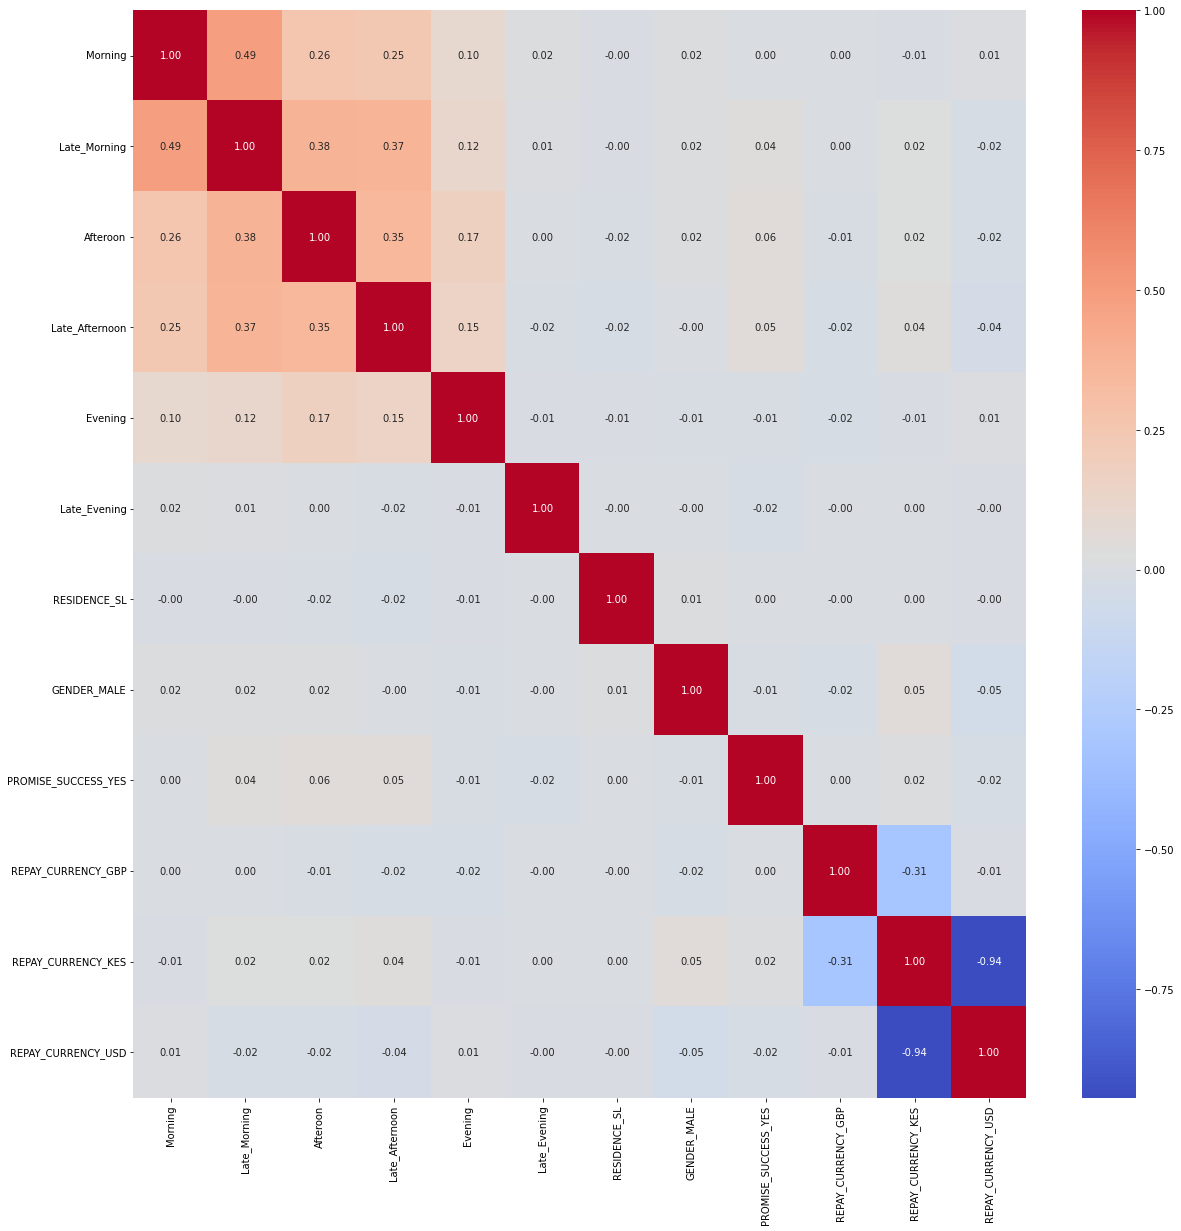

In [54]:
# Corelation Matrix
# added the parameter fmt =.2f for 2 decimal representation
# In a more general situation, when you have two independent variables that are very highly correlated, 
# you definitely should remove one of them because you run into the multicollinearity conundrum and your 
# regression model's regression coefficients related to the two highly correlated variables will be unreliable

plt.figure(figsize=(20,20))
sns.heatmap(df_final[list(df_final.columns)].corr(),annot=True,cmap="coolwarm",fmt=".2f")
plt.show()

In [55]:
# Binning, Replacing categories with values

df_final = df_final.replace({"CUSTOMER_RISK_STATUS" : {"A1":40,"A2":39,"A3":38,"A4":37,"A5":36,"A6":35,"A7":34,"A8":33,"A9":32,
                                           "A10":31,"A11":30,"A12":29,"A13":28,"A14":27,"A15":26,"A16":25,"A17":24,
                                           "A18":23,"A19":22,"A20":21,"B1":20,"B2":19,"B3":18,"B4":17,"B5":16,
                                           "B6":15,"B7":14,"B8":13,"B9":12,"B10":11,"B11":10,"B12":9,"B13":8,
                                           "B14":7,"B15":6,"B16":5,"B17":4,"B18":3,"B19":2,"B20":1 }})

# df_final = df_final.replace({"PREF_SESSION" : {'Morning':0,'Late_Morning':1,'Afteroon':2,'Late_Afternoon':3,
#                                                'Evening':4,'Late_Evening':5,'Night':6,'Late_Night':7,
#                                                'Early_Morning': 8}})

# df_final.to_csv("cleansed.csv")
df_final.tail()

,CUSTOMER_RISK_STATUS,INDUSTRY,CUSTOMER_STATUS,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,PREF_SESSION,RESIDENCE_SL,GENDER_MALE,PROMISE_SUCCESS_YES,REPAY_CURRENCY_GBP,REPAY_CURRENCY_KES,REPAY_CURRENCY_USD
5167,18,1002,4,2.0,1.0,1.0,6.0,1.0,0.0,Late_Afternoon,0,1,0,0,1,0
5168,28,1302,4,2.0,0.0,0.0,0.0,0.0,0.0,Morning,0,1,0,0,1,0
5169,28,1302,4,0.0,0.0,1.0,0.0,0.0,0.0,Afteroon,0,0,0,0,1,0
5170,25,1302,4,1.0,0.0,0.0,2.0,0.0,0.0,Late_Afternoon,0,0,1,0,1,0
5171,25,1302,4,0.0,0.0,0.0,1.0,0.0,0.0,Late_Afternoon,0,0,0,0,1,0


In [56]:
# spliting the data to dependent and independent variable
y = df_final['PREF_SESSION'].copy()
X = df_final.drop('PREF_SESSION', axis=1)

# Splitting the dataset into the Training set and Test set. test size is 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [57]:
# Feature Scaling
# there is no need to apply future scaling on dependent variable

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [58]:
param = {
            "n_estimators" : 50,
            "max_depth" : 10,
            "eta" : 0.1,
            "eval_metric" : "error",
            "objective" : "multi:softmax"
        }

In [59]:
# plot feature importance using built-in function
from xgboost import XGBClassifier
from xgboost import plot_importance,plot_tree
from matplotlib import pyplot
# fit model no training data
model = XGBClassifier(**param, num_class = y_train.nunique())

start_time = timer(None) # timing starts from this point for "start_time" variable
model.fit(X_train,y_train)
timer(start_time) # timing ends here for "start_time" variable


# # plot feature importance
# plot_importance(model,xlabel = 'count of the feature used across all tress')
# pyplot.show()

# sorted_idx = np.argsort(model.feature_importances_)[::-1]

# for index in sorted_idx:
#     print([X.columns[index], model.feature_importances_[index]]) 


 Time taken: 0 hours 0 minutes and 1.31 seconds.


In [60]:
print("Available model classess - ",model.classes_)
print("Total model classess - ",model.n_classes_)

Available model classess -  ['Afteroon' 'Evening' 'Late_Afternoon' 'Late_Morning' 'Morning']
Total model classess -  5


In [61]:
# Save the model
import joblib
joblib.dump(model, 'xgb_callsession_classifier.pkl')

#load the saved model and making predictions 
loaded_model = joblib.load('xgb_callsession_classifier.pkl')
y_pred = loaded_model.predict(X_test)

In [62]:
# confusion matrix for the predictions
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
cnf_matrix = confusion_matrix(y_true = np.array(y_test),y_pred = y_pred, labels = loaded_model.classes_)
print("Confusion matrix \n\n",cnf_matrix)

Confusion matrix 

 [[113   0   3   1   0]
 [  0   8   0   0   0]
 [  1   0 229   0   0]
 [  0   0   0 502   0]
 [  0   0   1   2 175]]


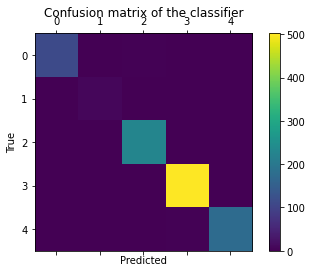

In [63]:
# Confusion matrix plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [64]:
# To print the accuracy score
# Accuracy is used when the True Positives and True negatives are more important while 
# F1-score is used when the False Negatives and False Positives are crucial.
# In real-life classification problems,imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on
print('Model Accuracy - ',round(accuracy_score(np.array(y_test), y_pred),3))

Model Accuracy -  0.992


In [65]:
#  F1 score - F-score or F-measure is a measure of a test's accuracy
# Sensitivity(recall) - true positive rate
# specificity - true negative rate
F1_score = f1_score(np.array(y_test), y_pred, average='weighted')
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = np.mean(FP.astype(float))
FN = np.mean(FN.astype(float))
TP = np.mean(TP.astype(float))
TN = np.mean(TN.astype(float))

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("F1 Score - ",np.round(F1_score,3))
print("Sensitivity Score - ",np.round(TPR,3))
print("Specificity Score- ",np.round(TNR,3))
print("False Positive - ",np.round(FPR,3))
print("False Negative - ",np.round(FNR,3))

F1 Score -  0.992
Sensitivity Score -  0.992
Specificity Score-  0.998
False Positive -  0.002
False Negative -  0.008


In [65]:
# XGB model with GridsearchCV parameter tuning

# max_depth  - Maximum depth of a tree
# n_estimators - no of important estimators
# eta - Step size shrinkage used in update to prevents overfitting
# min_child_weight = Minimum sum of instance weight (hessian) needed in a child.
# gamma - gamma regression with log-link. Output is a mean of gamma distribution
# subsample - Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly 
# sample half of the training data prior to growing trees. and this will prevent overfitting.
# colsample_bytree - This is a family of parameters for subsampling of columns

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer,f1_score,precision_score,recall_score,accuracy_score

xgb_model = xgb.XGBClassifier()

params = {
            'objective': ['multi:softmax'],
            'num_class': [7],
            'eval_metric': ['error'],
            'max_depth': np.arange(6,11,1).tolist(),
            'n_estimators': [10,25,50,100],
            'eta':[0.1,0.2,0.3],
            'subsample': [0.3,0.5,0.8,1],
            'random_state': [4]
            
        }

# scorers = {
#             'f1_score':make_scorer(f1_score),
#             'precision_score': make_scorer(precision_score),
#             'recall_score': make_scorer(recall_score),
#             'accuracy_score': make_scorer(accuracy_score)
#           }

scorers = {
            'accuracy_score': make_scorer(accuracy_score)
          }

k_fold = StratifiedKFold(n_splits=5, shuffle = True)

# param_grid - Dictionary with parameters names (str) as keys and lists of parameter settings to try as values,
# or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored. 
# scoring - Strategy to evaluate the performance of the cross-validated model on the test set
# n_jobs - Number of jobs to run in parallel. None means 1 unless in a joblib.parallel_backend context.
# -1 means using all processors.
# cv - cross-validation generator or an iterable,Determines the cross-validation splitting strategy.
# refit - Refit an estimator using the best found parameters on the whole dataset
xgb_model = GridSearchCV(xgb_model, 
                    param_grid = params, 
                    scoring = scorers, 
                    n_jobs = -1,
                    cv = k_fold.split(X_train,y_train),
                    refit = "accuracy_score")

start_time = timer(None) # timing starts from this point for "start_time" variable

xgb_model.fit(X_train,y_train)
# Dictionary of best parameters
best_pars = xgb_model.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = xgb_model.best_estimator_
# Save model with best parameters
pickle.dump(xgb_model.best_estimator_, open("xgb_callsession_classifier.pickle", "wb"))

timer(start_time) # timing ends here for "start_time" variable

/home/sabarish/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/sabarish/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/sabarish/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: Use

/home/sabarish/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/sabarish/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/sabarish/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: Use

/home/sabarish/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/sabarish/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/sabarish/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: Use

KeyboardInterrupt: 

In [67]:
# best estimator for XGB
print("Best estimator for XGB model",xgb_model.best_estimator_)

# load saved modes
XGB_model = pickle.load(open("xgb_callsession_classifier.pickle", "rb"))
y_pred = XGB_model.predict(X_test)

NameError: name 'xgb_model' is not defined

In [ ]:
# confusion matrix for the predictions
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
cnf_matrix = confusion_matrix(y_true = np.array(y_test),y_pred = y_pred, labels = loaded_model.classes_)
print("Confusion matrix \n\n",cnf_matrix)

In [ ]:
# Confusion matrix plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cnf_matrix)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# To print the accuracy score
# Accuracy is used when the True Positives and True negatives are more important while 
# F1-score is used when the False Negatives and False Positives are crucial.
# In real-life classification problems,imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on
print('Model Accuracy - ',round(accuracy_score(np.array(y_test), y_pred),3))

In [ ]:
#  F1 score - F-score or F-measure is a measure of a test's accuracy
# Sensitivity(recall) - true positive rate
# specificity - true negative rate
F1_score = f1_score(np.array(y_test), y_pred, average='weighted')
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = np.mean(FP.astype(float))
FN = np.mean(FN.astype(float))
TP = np.mean(TP.astype(float))
TN = np.mean(TN.astype(float))

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("F1 Score - ",np.round(F1_score,3))
print("Sensitivity Score - ",np.round(TPR,3))
print("Specificity Score- ",np.round(TNR,3))
print("False Positive - ",np.round(FPR,3))
print("False Negative - ",np.round(FNR,3))

In [ ]:
# # best estimator for XGB
# print("Best estimator for XGB model",gb_model.best_estimator_)

# # load saved modes
# XGB_model = pickle.load(open("xgb_callsession_classifier.pickle", "rb"))

# # plot feature importance using built-in function
# from xgboost import plot_importance
# from matplotlib import pyplot

# #plot feature importance
# plot_importance(XGB_model)
# pyplot.show()

In [ ]:
# plot feature importance using built-in function
#from numpy import loadtxt
#from xgboost import XGBClassifier
#from xgboost import plot_importance
#from matplotlib import pyplot
# fit model no training data
#model = XGBClassifier()
#model.fit(X_sc, y)
#plot feature importance
# plot_importance(model)
# pyplot.show()

In [ ]:
#feature_important = model.get_booster().get_score(importance_type='weight')
#keys = list(feature_important.keys())
#values = list(feature_important.values())

#data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
#data.plot(kind='barh')

In [ ]:
# plot_tree(model)
# pyplot.rcParams["figure.figsize"] = (500,100)
# pyplot.show()

In [68]:
mysql_connection = mysql.connector.connect(**config)
dfs = pd.read_sql("SELECT * FROM classification$model$information WHERE ID = ( SELECT MAX(ID) FROM classification$model$information where MODEL_NAME ='xgb_callsession_classifier')", con=mysql_connection)
mysql_connection.close()
dfs.head()

,ID,MODEL_NAME,FILE_NAME,SCALAR_NAME,ACCURACY,F1_SCORE,SENSITIVITY,SPECIFICITY,FALSE_POSITIVE,FALSE_NEGATIVE,DATASET_COLUMNS,ONEHOT_LIST,CREATED_BY,CREATED_ON,UPDATED_BY,UPDATED_ON
0,1,xgb_callsession_classifier,Models/xgb_callsession_classifier202206131331.pkl,Models/xgb_callsession_scalar202206131331.pkl,0.996,0.996,1.0,0.999,0.001,0.004,"['CUSTOMER_RISK_STATUS', 'INDUSTRY', 'CUSTOMER...","[['KE', 'SL'], ['MALE', 'FEMALE'], ['NO', 'YES...",ML_USER,2022-06-13 13:31:20,None,None


In [71]:
inputdata = {
            "ID":100165,
            "CUSTOMER_RISK_STATUS":15,
            "INDUSTRY": 2405,
            "RESIDENCE" :"KE",
            "GENDER":"MALE",
            "PROMISE_SUCCESS":"YES",
            "REPAY_CURRENCY":"KES",
            "CUSTOMER_STATUS":4,
            "STAGE":"COLLECTION"
        }

ONEHOT_LIST = ["RESIDENCE","GENDER","PROMISE_SUCCESS","REPAY_CURRENCY","STAGE"]

INPUT_ONEHOT =[['GB','KE','KG','NA','NG','NL','RW','UG','US','ZW'],['MALE','FEMALE'],['YES','NO'],['KES','USD'],
                ['Deceased','Internal Customer','NORMAL CLIENT','Rts Mail/New Address Required',
                 'Statutory Entity','Watch List / Hotlist'],['COLLECTION','REPOSSESSION']]

INPUT_ONEHOT = [['KE', 'SL'], ['MALE', 'FEMALE'], ['NO', 'YES'], ['KES', 'USD', 'GBP', 'EUR'], ['COLLECTION']]

In [72]:
data = {}
for i in range(0,len(ONEHOT_LIST)):
    for j in INPUT_ONEHOT[i]:  
        if j in inputdata[ONEHOT_LIST[i]]:
            data[ONEHOT_LIST[i]+'_'+ j] = [1]
        else:
            data[ONEHOT_LIST[i]+'_'+ j] = [0]
            
data

{'RESIDENCE_KE': [1],
 'RESIDENCE_SL': [0],
 'GENDER_MALE': [1],
 'GENDER_FEMALE': [0],
 'PROMISE_SUCCESS_NO': [0],
 'PROMISE_SUCCESS_YES': [1],
 'REPAY_CURRENCY_KES': [1],
 'REPAY_CURRENCY_USD': [0],
 'REPAY_CURRENCY_GBP': [0],
 'REPAY_CURRENCY_EUR': [0],
 'STAGE_COLLECTION': [1]}

In [76]:
d = {'ID':[inputdata['ID']],'CUSTOMER_RISK_STATUS':[int(inputdata['CUSTOMER_RISK_STATUS'])],
     'CUSTOMER_STATUS':[int(inputdata['CUSTOMER_STATUS'])],'INDUSTRY':[inputdata['INDUSTRY']]}
d

{'ID': [100165],
 'CUSTOMER_RISK_STATUS': [15],
 'CUSTOMER_STATUS': [4],
 'INDUSTRY': [2405]}

In [77]:
from jsonmerge import merge
import pandas as pd

result = merge(d, data)
print(result)
df1 = pd.DataFrame(data=result)
df1.head()

{'ID': [100165], 'CUSTOMER_RISK_STATUS': [15], 'CUSTOMER_STATUS': [4], 'INDUSTRY': [2405], 'RESIDENCE_KE': [1], 'RESIDENCE_SL': [0], 'GENDER_MALE': [1], 'GENDER_FEMALE': [0], 'PROMISE_SUCCESS_NO': [0], 'PROMISE_SUCCESS_YES': [1], 'REPAY_CURRENCY_KES': [1], 'REPAY_CURRENCY_USD': [0], 'REPAY_CURRENCY_GBP': [0], 'REPAY_CURRENCY_EUR': [0], 'STAGE_COLLECTION': [1]}


,ID,CUSTOMER_RISK_STATUS,CUSTOMER_STATUS,INDUSTRY,RESIDENCE_KE,RESIDENCE_SL,GENDER_MALE,GENDER_FEMALE,PROMISE_SUCCESS_NO,PROMISE_SUCCESS_YES,REPAY_CURRENCY_KES,REPAY_CURRENCY_USD,REPAY_CURRENCY_GBP,REPAY_CURRENCY_EUR,STAGE_COLLECTION
0,100165,15,4,2405,1,0,1,0,0,1,1,0,0,0,1


In [78]:
mysql_connection = mysql.connector.connect(**config)
dfa = pd.read_sql_query("select ID,TIME_STAMP from customer$information where ID = '"+str(inputdata['ID'])+"' and PROMISE_SUCCESS = '"+inputdata['PROMISE_SUCCESS']+"'", con=mysql_connection)
mysql_connection.close()
dfa.tail()

,ID,TIME_STAMP


In [79]:
dfa['TIME_STAMP'] = pd.to_datetime(dfa['TIME_STAMP'], errors='coerce')
dfa['SESSION'] = pd.cut(dfa.TIME_STAMP.dt.hour, bins=split, labels=session, include_lowest=True)

# Grouping the ID with sessions to get each customer call count against each session
dfa['FREQ'] = dfa.groupby(["ID","SESSION"])['SESSION'].transform('count')

dfa = dfa.pivot_table(index=['ID'], columns='SESSION', values='FREQ', fill_value=0, dropna=False).reset_index()
dfa.tail()

SESSION,ID,Late_Night,Early_Morning,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,Night


In [80]:
dfa['ID']=dfa['ID'].astype(int)
df = pd.merge(dfa, df1, on=['ID'])
df.head()

,Late_Night,Early_Morning,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,Night,ID,...,RESIDENCE_SL,GENDER_MALE,GENDER_FEMALE,PROMISE_SUCCESS_NO,PROMISE_SUCCESS_YES,REPAY_CURRENCY_KES,REPAY_CURRENCY_USD,REPAY_CURRENCY_GBP,REPAY_CURRENCY_EUR,STAGE_COLLECTION


In [81]:
df = df[eval(dfs['DATASET_COLUMNS'][0])]
df.head()

,CUSTOMER_RISK_STATUS,INDUSTRY,CUSTOMER_STATUS,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,RESIDENCE_SL,GENDER_MALE,PROMISE_SUCCESS_YES,REPAY_CURRENCY_GBP,REPAY_CURRENCY_KES,REPAY_CURRENCY_USD


In [82]:
mysql_connection = mysql.connector.connect(**config)
dfc = pd.read_sql_query("select ID,TIME_STAMP from customer$information where ID = '100' and PROMISE_SUCCESS = '"+inputdata['PROMISE_SUCCESS']+"'", con=mysql_connection)
mysql_connection.close()
len(dfc)

0

In [83]:
data1 = {}

for i in session:
    data1[i] = [0]    
data1

{'Late_Night': [0],
 'Early_Morning': [0],
 'Morning': [0],
 'Late_Morning': [0],
 'Afteroon': [0],
 'Late_Afternoon': [0],
 'Evening': [0],
 'Late_Evening': [0],
 'Night': [0]}

In [84]:
from jsonmerge import merge

result = merge(d, data)
result = merge(result,data1)
df1 = pd.DataFrame(data=result)
df1.head()

,ID,CUSTOMER_RISK_STATUS,CUSTOMER_STATUS,INDUSTRY,RESIDENCE_KE,RESIDENCE_SL,GENDER_MALE,GENDER_FEMALE,PROMISE_SUCCESS_NO,PROMISE_SUCCESS_YES,...,STAGE_COLLECTION,Late_Night,Early_Morning,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,Night
0,100165,15,4,2405,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [85]:
df1 = df1[eval(dfs['DATASET_COLUMNS'][0])]
df1.head()

,CUSTOMER_RISK_STATUS,INDUSTRY,CUSTOMER_STATUS,Morning,Late_Morning,Afteroon,Late_Afternoon,Evening,Late_Evening,RESIDENCE_SL,GENDER_MALE,PROMISE_SUCCESS_YES,REPAY_CURRENCY_GBP,REPAY_CURRENCY_KES,REPAY_CURRENCY_USD
0,15,2405,4,0,0,0,0,0,0,0,1,1,0,1,0
